<img src="GCD_logo.png" align="right" style="float" width="50">
<font color="#CA3532"><h1 align="left">News Categorizer</h1></font>
<font color="#6E6E6E"><h2 align="left">NLP's Quest to Classify Meneame.net News</h2></font> 
<font color="#6E6E6E"><h3 align="left"></h3></font> 


<a id="5"></a><h1 style='background:#26A2AB; border:1; color:white'><center>Guillem Miralles</center></h1>

### INDEX:
0. Libraries
1. Reading and Exploratory Analysis
2. Class Splitting
3. Normalization
4. Reading and Post-Preprocessing
5. Sparse Vectors
6. Class Balancing
7. Topic Modeling (LSA) Modeling
8. Doc2Bow Modeling
9. Keras Modeling
10. Model Improvement
11. Test Set
12. Conclusion

### 0. Libraries:

In [1]:
# Básicos
import pandas as pd
import numpy as np


# Plots
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

# Extracción de características
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# PLN
import os, re, string, spacy

# Barra progreso
from tqdm import tqdm

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.svm import LinearSVC


# Balanceo
import imblearn
from imblearn.over_sampling import SMOTE

#Méticas
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Keras:
import itertools

%matplotlib inline
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

#LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Otros
import warnings
from gensim.models import Doc2Vec

import gensim
from gensim.models.doc2vec import TaggedDocument
import re

C:\Users\guill\Anacona\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 1. Reading and Exploratory Analysis


We are going to read the data. This dataset is available at http://oceano.uv.es/SB/meneame.csv.zip and it includes information about the news that appear on the homepage of the website www.meneame.net. The data ranges from December 2005 to December 4, 2017. There are 177,000 observations with 17 variables: news, users, submission time, negative votes, positive votes, description, etc. Most of the news are in Spanish. The class to predict is the type of news (SUB column in the database) based on the columns NOTICIA and EXTRACTO. Let's proceed with the reading.

In [5]:
warnings.filterwarnings("ignore")

df = pd.read_csv('./data/data.csv',sep=';')
df.head()

,index,noticia,link_noticia,web,usuario,id_usuario,fecha_envio,fecha_publicacion,meneos,clicks,comentarios,votos_positivos,votos_anonimos,votos_negativos,karma,sub,extracto
0,2869055,Ruptura inesperada de un iceberg gigante desp...,https://www.bas.ac.uk/media-post/giant-west-an...,bas.ac.uk,jm22381,21061,1512164817,1512382803,73,1057,10,55,18,2,340,cultura,Una animación del iceberg gigante que nació de...
1,2869761,"El MIT logra hacer escáneres 3D baratos 1,000...",https://gizmodo.com/mit-figured-out-how-to-mak...,gizmodo.com,CalzadorCalzado,553023,1512352183,1512381302,73,772,17,43,30,1,331,tecnología,Los científicos ya desarrollaron una tecnologí...
2,2869841,"“Lárgame un cilindrín, fotero”",http://www.teknoplof.com/2017/12/04/largame-un...,teknoplof.com,gobolino,511338,1512377483,1512379520,89,1608,34,53,36,5,396,ocio,"‘La gran superproducción‘ es, sin ningún géner..."
3,2869859,El Tribunal Supremo deja en prisión a Junquer...,http://www.eldiario.es/politica/Tribunal-Supre...,eldiario.es,Raditz,382296,1512378799,1512379503,171,889,90,98,73,1,452,actualidad,El juez Llarena acuerda libertad previo pago d...
4,2869823,La Fiscalía pide imputar a Aguirre y Gallardó...,http://www.elboletin.com/noticia/156624/nacion...,elboletin.com,Danichaguito,407263,1512375033,1512379203,354,353,39,144,210,0,324,actualidad,La Fiscalía en el caso Lezo ha solicitado impu...


Let's see what type of variables we have in our DataFrame.

In [6]:
df.dtypes

index                 int64
noticia              object
link_noticia         object
web                  object
usuario              object
id_usuario            int64
fecha_envio           int64
fecha_publicacion     int64
meneos                int64
clicks               object
comentarios          object
votos_positivos       int64
votos_anonimos        int64
votos_negativos       int64
karma                 int64
sub                  object
extracto             object
dtype: object

In [7]:
df.describe()

,index,id_usuario,fecha_envio,fecha_publicacion,meneos,votos_positivos,votos_anonimos,votos_negativos,karma
count,1.775090e+05,177509.000000,1.775090e+05,1.775090e+05,177509.000000,177509.000000,177509.000000,177509.000000,177509.000000
mean,1.297267e+06,143099.818257,1.309050e+09,1.309076e+09,585.399343,239.303568,346.095775,3.755410,589.655708
std,8.865680e+05,142039.798847,1.016085e+08,1.016080e+08,448.844704,124.185722,337.832602,7.831172,147.497924
min,1.000000e+00,1.000000,1.133928e+09,1.133928e+09,10.000000,6.000000,0.000000,0.000000,0.000000
25%,5.005330e+05,24647.000000,1.224060e+09,1.224073e+09,303.000000,161.000000,140.000000,0.000000,494.000000
50%,1.199276e+06,90321.000000,1.300094e+09,1.300107e+09,448.000000,211.000000,244.000000,2.000000,580.000000
75%,2.105331e+06,223382.000000,1.390993e+09,1.391015e+09,728.000000,288.000000,453.000000,4.000000,675.000000
max,2.869859e+06,566102.000000,1.512379e+09,1.512383e+09,12389.000000,3315.000000,9597.000000,246.000000,6937.000000


Let's check the categories (variable to predict) in our DataFrame.

In [8]:
categories = df.groupby('sub')
print("total categories:", categories.ngroups)
print(categories.size())

total categories: 115
sub
ACME               1
AEDE               2
Abuso_Animal      16
Alimentación       2
Animales           1
                ... 
softlibre         10
tecnología      4421
trenes            11
veganismo          1
Лhcdss             4
Length: 115, dtype: int64



We have many classes (115), let's see which of these are sufficiently representative in our dataset.

<AxesSubplot:ylabel='sub'>

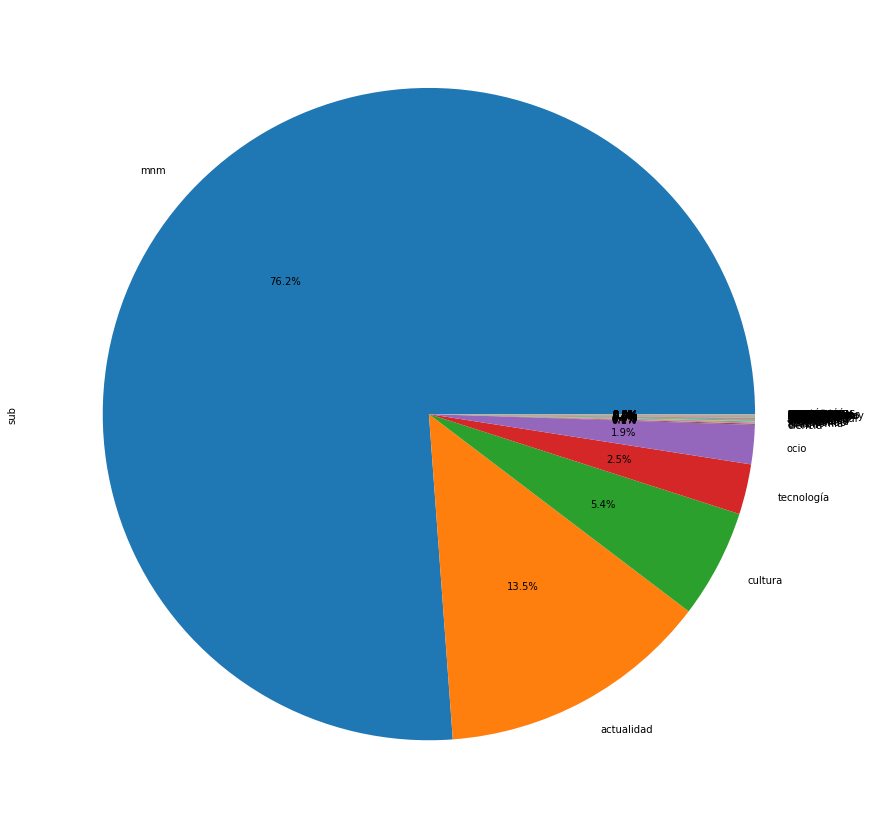

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

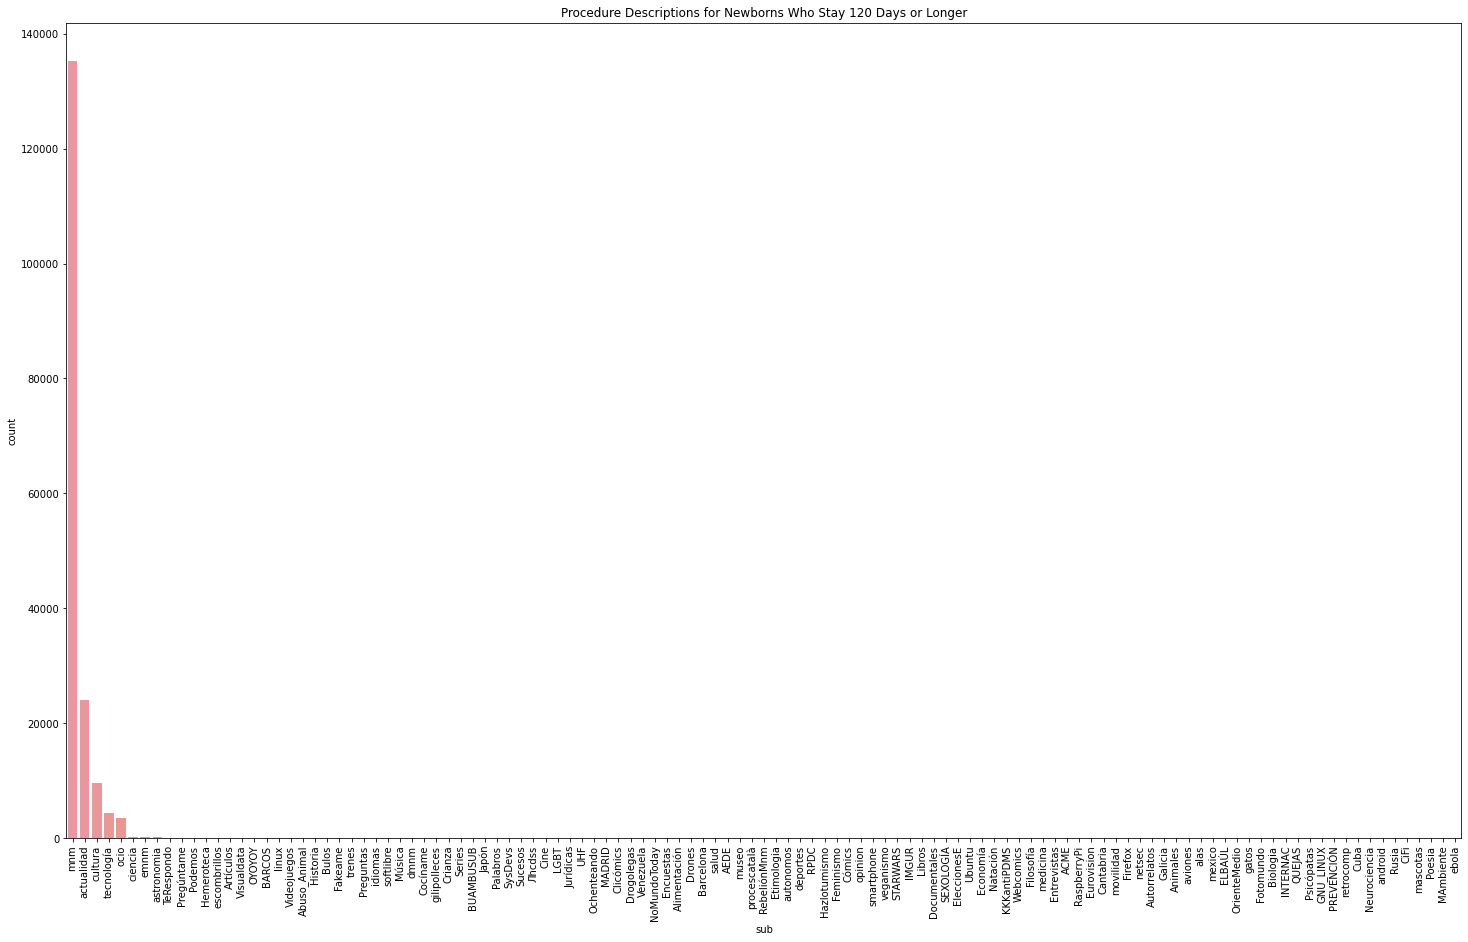

In [10]:
f, ax = plt.subplots(figsize=(25, 15))
sns.countplot(x='sub', data = df,
             order = df['sub'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Procedure Descriptions for Newborns Who Stay 120 Days or Longer')
plt.show()

We can see that the dataset is quite unbalanced, as there is a **76.2%** of news articles that belong to the category "mnm". "mnm" is a category that comes from the Menéame website and does not represent any specific topic. That's why it is important for us to remove this class from our data in order to perform accurate predictions.

In [11]:
df_mnm = df.loc[df['sub'] == 'mnm']
df = df.loc[df['sub'] != 'mnm']

<AxesSubplot:ylabel='sub'>

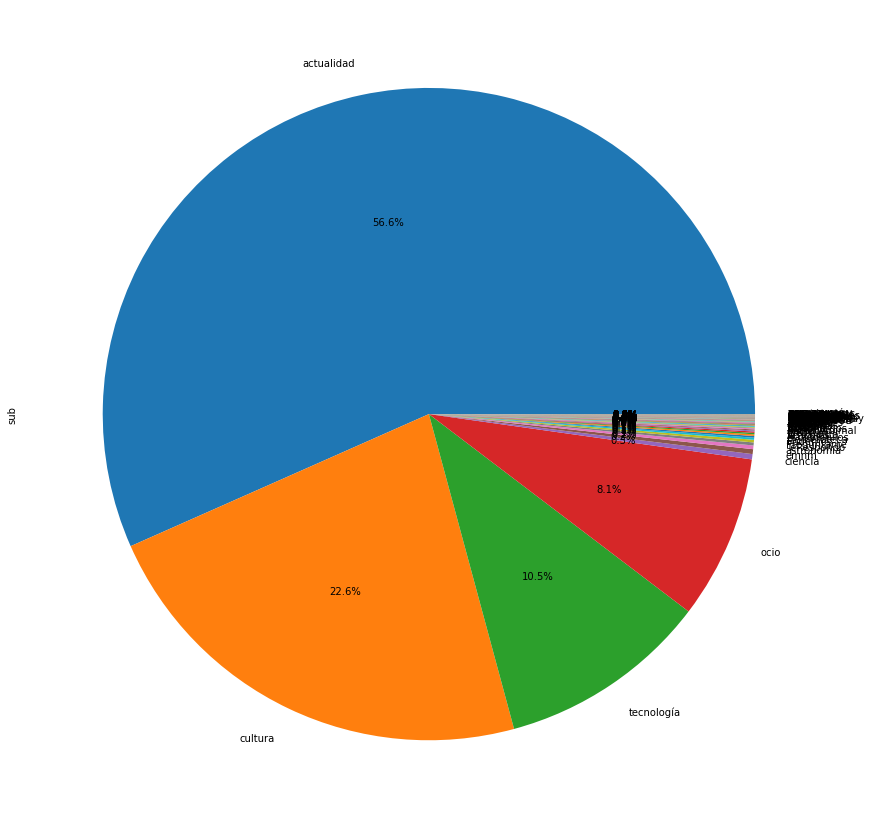

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

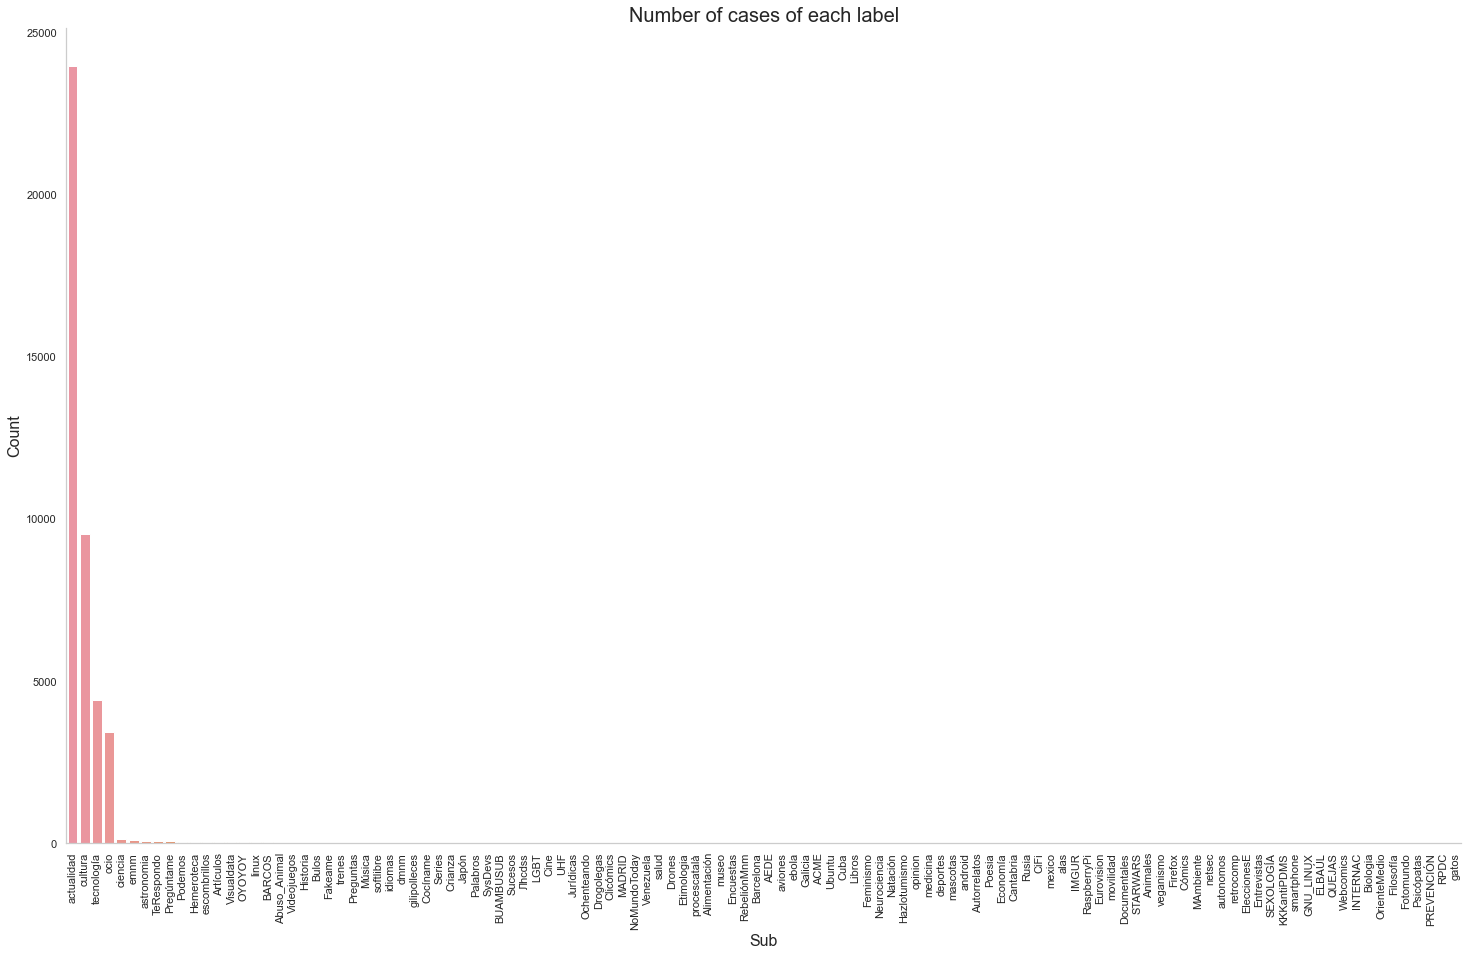

In [15]:
# Set the style of the plot
sns.set(style='whitegrid')

# Create the figure and axes
f, ax = plt.subplots(figsize=(25, 15))

# Plot the countplot
sns.countplot(x='sub', data=df, order=df['sub'].value_counts().index)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Set the title and increase font size
plt.title('Number of cases of each label', fontsize=20)

# Set the labels for x and y axes with increased font size
plt.xlabel('Sub', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Add a grid to the plot
ax.grid(axis='y')

# Remove the top and right spines of the plot
sns.despine()

# Show the plot
plt.show()

We can see that there are 4 relevant classes in our data that represent 98.7% of the total. Therefore, we will focus on these four classes: technology, entertainment, current affairs, and culture. We will perform predictions only on the data that belongs to these categories.

### 2. Class Splitting

In [16]:
df = df[df['sub'].isin(['tecnología','ocio','actualidad','cultura'])]
df['sub'].describe()

count          41365
unique             4
top       actualidad
freq           23959
Name: sub, dtype: object

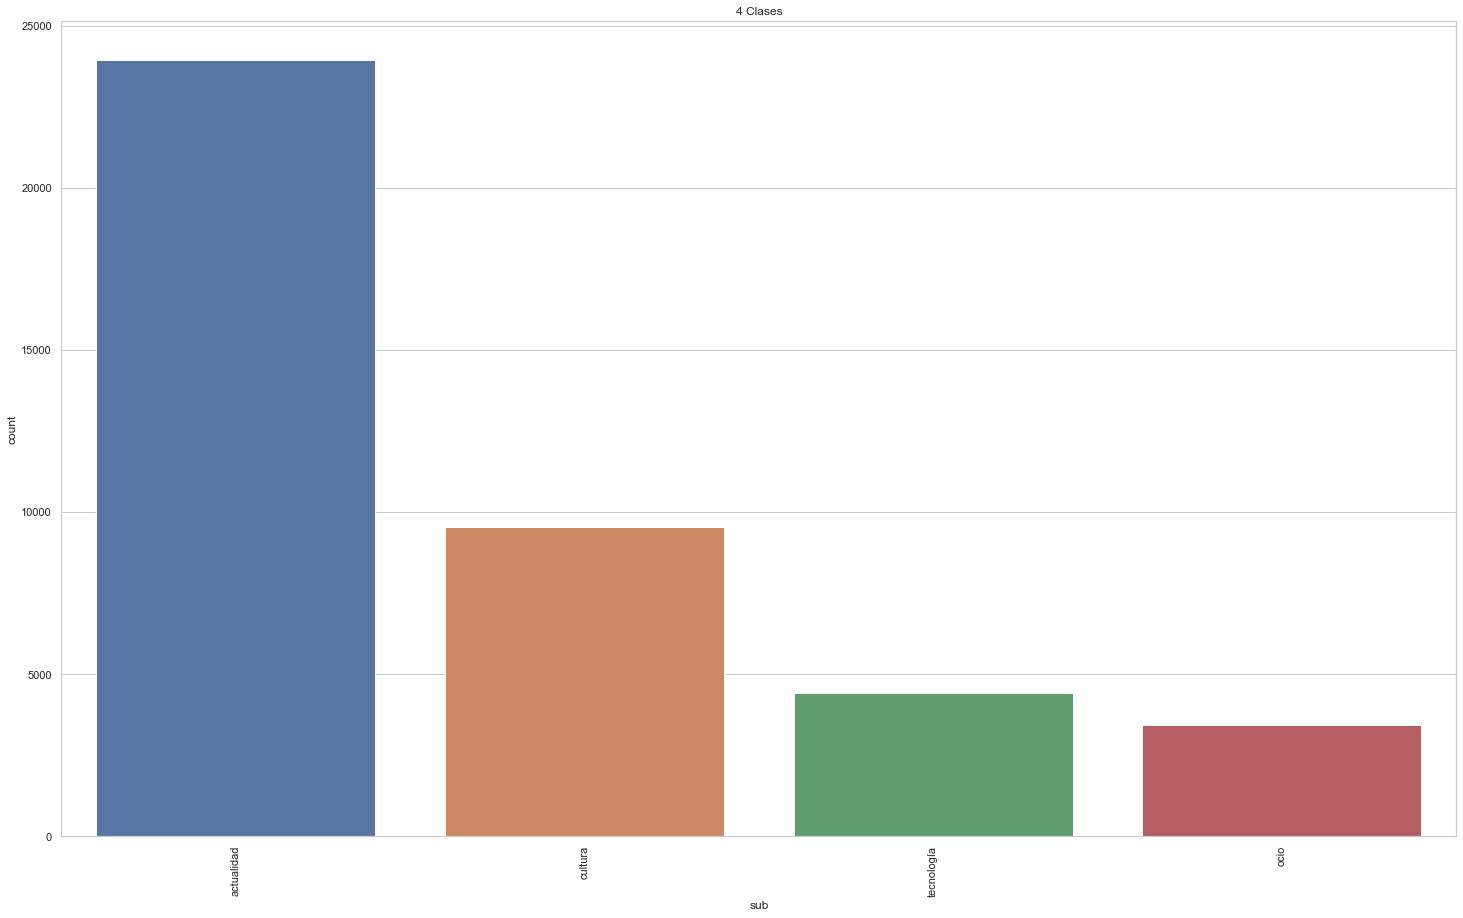

In [17]:
f, ax = plt.subplots(figsize=(25, 15))
sns.countplot(x='sub', data = df,
             order = df['sub'].value_counts().index)
plt.xticks(rotation=90)
plt.title('4 Clases')
plt.show()

<AxesSubplot:ylabel='sub'>

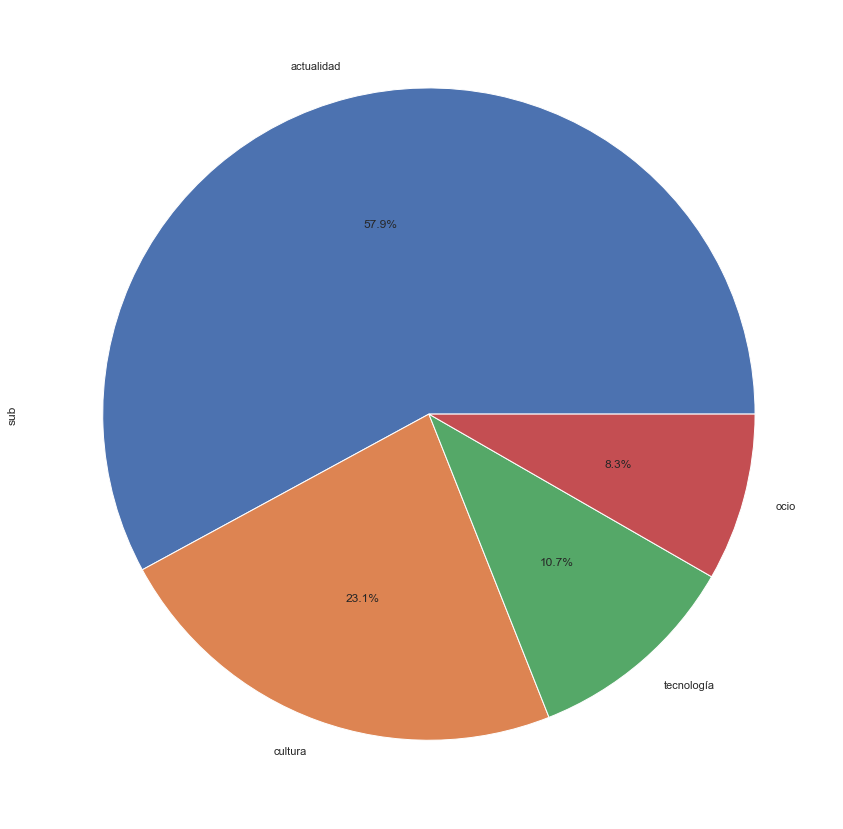

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df['sub'].value_counts().plot.pie( autopct = '%1.1f%%')

As can be clearly seen in these graphs, the classes are quite imbalanced. "Current affairs" represents 57.9% of the data, while "entertainment" only represents 8.3%. Therefore, later on, we will perform class balancing to see the improvement it brings to the models.

In [19]:
df = df.dropna()
X = df[['noticia','extracto']]
y = df[['sub']]

In [20]:
X.head()

,noticia,extracto
0,Ruptura inesperada de un iceberg gigante desp...,Una animación del iceberg gigante que nació de...
1,"El MIT logra hacer escáneres 3D baratos 1,000...",Los científicos ya desarrollaron una tecnologí...
2,"“Lárgame un cilindrín, fotero”","‘La gran superproducción‘ es, sin ningún géner..."
3,El Tribunal Supremo deja en prisión a Junquer...,El juez Llarena acuerda libertad previo pago d...
4,La Fiscalía pide imputar a Aguirre y Gallardó...,La Fiscalía en el caso Lezo ha solicitado impu...


In [21]:
y.describe()

,sub
count,41327
unique,4
top,actualidad
freq,23933


### 3. Normalización:

We normalize the text to obtain a canonical form of it and to be able to build models with higher accuracy.

In [22]:
nlp=spacy.load('es_core_news_md')

#lista de stop-words que tendremos en nuestras noticias
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and not tok.isdigit() and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [23]:
for i in tqdm(range(len(X)), desc='Normalizando texto...'):
    X.iloc[i][0] = clean_text(X.iloc[i][0])
    X.iloc[i][1] = clean_text(X.iloc[i][1])

Normalizando texto...: 100%|█████████████████████████████████████████████████████| 41327/41327 [17:46<00:00, 38.76it/s]


In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [25]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33061 (33061, 2)       X_test 8266 (8266, 2)
y_train: 33061 (33061, 1)       y_test 8266 (8266, 1)
------------------------------------------------------


In [26]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: False
NAs X_test: False


In [28]:
X_train.to_csv('./data/X_train.csv')
X_test.to_csv('./data/X_test.csv')
y_train.to_csv('./data/y_train.csv')
y_test.to_csv('./data/y_test.csv')

We will create the CSV files because the normalization process is quite lengthy, and we don't want to execute it every time we want to continue the execution.

### 4. Post-Preprocessing

Let's read the CSV files that we created earlier. From this point, we can re-run the file without having to perform the normalization again.

In [29]:
X_train = pd.read_csv('data/X_train.csv',usecols=['noticia','extracto'])
X_test = pd.read_csv('data/X_test.csv',usecols=['noticia','extracto'])
y_train = pd.read_csv('data/y_train.csv',usecols=['sub'])
y_test = pd.read_csv('data/y_test.csv',usecols=['sub'])


We can see that during the reading process, some null values are encountered.

In [30]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: True
NAs X_test: True


In [31]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33061 (33061, 2)       X_test 8266 (8266, 2)
y_train: 33061 (33061, 1)       y_test 8266 (8266, 1)
------------------------------------------------------


In [32]:
na_free = X_train.dropna()
only_na = X_train[np.invert(X_train.index.isin(na_free.index))]
X_train = na_free
y_train = y_train.drop(labels=only_na.index)
#################################################################
na_free = X_test.dropna()
only_na = X_test[np.invert(X_test.index.isin(na_free.index))]
X_test = na_free
y_test = y_test.drop(labels=only_na.index)

In [33]:
print('NAs X_train:',X_train.isnull().values.any())
print('NAs X_test:',X_test.isnull().values.any())

NAs X_train: False
NAs X_test: False


We can see that we are getting rid of 38 null values in the train set and 13 null values in the test set.



In [34]:
print('-'*21,' Longitud ','-'*21)
print('X_train:',len(X_train), X_train.shape,' '*5,'X_test',len(X_test),X_test.shape)
print('y_train:',len(y_train),y_train.shape,' '*5,'y_test',len(y_test),y_test.shape)
print('-'*54)

---------------------  Longitud  ---------------------
X_train: 33033 (33033, 2)       X_test 8260 (8260, 2)
y_train: 33033 (33033, 1)       y_test 8260 (8260, 1)
------------------------------------------------------


#### New Column

In that new column, we will have the part of the news and the part of the excerpt together. To do this, we create a function.

In [35]:
def df_join(df):
    df['noticia_completa'] = df['noticia'].map(str)+ ' ' + df['extracto']
    dfnew = df['noticia_completa']

    return dfnew
    
# Estos conjuntos nos servirán al final para probar los modelos con el conjunto test:
X_train2 = df_join(X_train)
X_test2 = df_join(X_test)

In [36]:
X_train2[3]

'psoe valenciano rubalcaba obtiene peor resultado historia psoe aún había tocado fondo los resultados las elecciones europeas celebradas este domingo han dado los socialistas peor resultado historia por debajo incluso del 27 que obtuvieron las elecciones municipales efecto las declaraciones machistas del candidato conservador miguel arias cañete fuerte desgaste del partido gobierno los socialistas sólo resisten andalucía extremadura asturias'

#### Train / Validation split:


We are going to split the dataset into a validation set. In the end, we will use the best-performing models on the test set.

In [37]:
Xtr,Xts,ytr,yts = train_test_split(X_train2,y_train,test_size=0.2, random_state=42)

### 5. Sparce Vectors

We are going to perform feature extraction where we convert the text documents into numerical vectors. This way, we will be able to train our models. To begin with, we will use the Space Model vectors: Bag of Words and TF-IDF.

In [38]:
#Creamos los vectorizadores:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [39]:
# Vamos a entrenar con el conjunto de train los vectorizadores:
bow_train_x = bow_vectorizer.fit_transform(Xtr)  
tfidf_train_x = tfidf_vectorizer.fit_transform(Xtr) 

# Ahora lo aplicamos sobre el conjunto test (el vector ya entrenado):
bow_test_x = bow_vectorizer.transform(Xts) 
tfidf_test_x = tfidf_vectorizer.transform(Xts)

In this section, we will build different models and analyze the results they provide for the f1_score metric. F1_score is a good metric to measure performance on imbalanced classes because accuracy can be biased by the majority class.

In [40]:
lista_resultados = [] #Lista para guardar los resultados del modelo
target_names = ['Actualidad','Cultura','Ocio','Tecnología']

#### 5.1. LOGISTIC REGRESSION:
First, we will analyze the model using the Bag of Words (BoW) matrix, and then we will perform it using TF-IDF.

f1 score: 75.74%


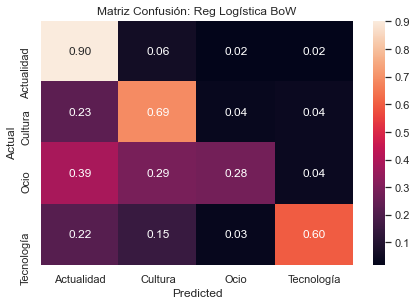

In [41]:
warnings.filterwarnings("ignore")

# Modelo con BoW:
model = LogisticRegression(solver='liblinear').fit(bow_train_x, ytr)

# Predicción
prediction = model.predict(bow_test_x)
m1_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m1_1))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


We can see that the model achieves high accuracy in predicting "current affairs," but we encounter significant issues with the "entertainment" category, where the model performs poorly.


f1 score: 74.68%


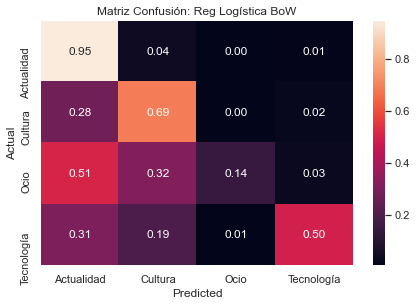

In [42]:
warnings.filterwarnings("ignore")

# Modelo con TF-IDF:
model = LogisticRegression(solver='liblinear').fit(tfidf_train_x, ytr)

# Predicción
prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m1_2))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista 
lista_resultados.append(('Reg Logística',m1_1,m1_2))

#### 5.2. Multinomial NB:

f1 score: 77.27%


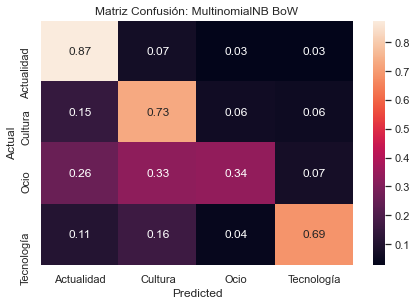

In [43]:
#Modelo:
model = MultinomialNB(alpha=0.05).fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m2_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m2_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



f1 score: 75.92%


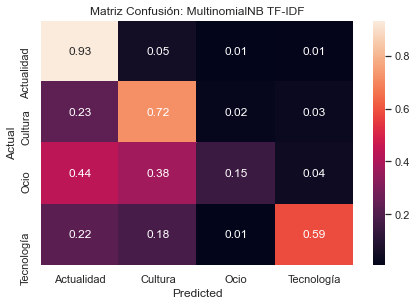

In [44]:
#Modelo
model = MultinomialNB(alpha=0.05).fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m2_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m2_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista 
lista_resultados.append(('Multinomial NB',m2_1,m2_2))

#### 5.3. SGDC Classifier

f1 score: 73.97%


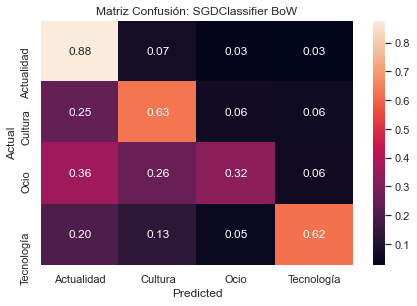

In [45]:
#Modelo
model = SGDClassifier(loss='hinge').fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m3_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 75.58%


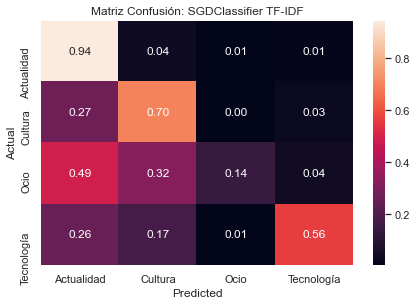

In [46]:
#Modelo
model = SGDClassifier(loss='hinge').fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m3_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#Añadimos a la lista
lista_resultados.append(('SGDC Classifier',m3_1,m3_2))

#### 5.4. Linear SVC

f1 score: 73.43%


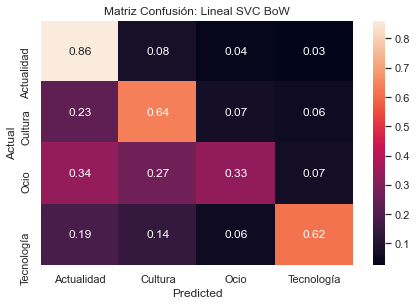

In [47]:
from sklearn.svm import LinearSVC
#Modelo
model = LinearSVC().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m4_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Lineal SVC BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 73.43%


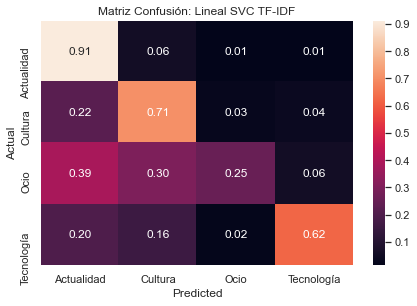

In [48]:
#Modelo
model = LinearSVC().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Lineal SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Linear SVC',m4_1,m4_2))

#### 5.5. Descicion Tree Classifier

Now, let's perform classification using decision trees.

f1 score: 60.48%


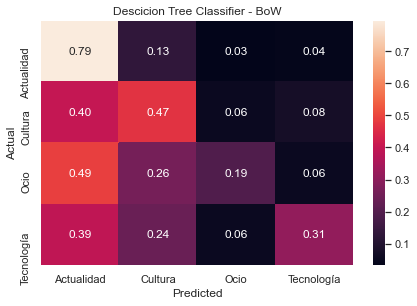

In [49]:
#Modelo
model = DecisionTreeClassifier().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m5_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m5_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Descicion Tree Classifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 60.2%


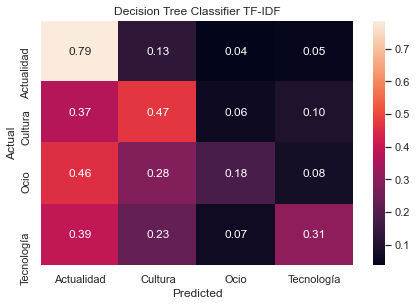

In [50]:
#Modelo
model = DecisionTreeClassifier().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m5_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m5_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Decision Tree Classifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Decision Tree Clasifier',m5_1,m5_2))

#### 5.6. Random Forest Clasifier

f1 score: 63.81%


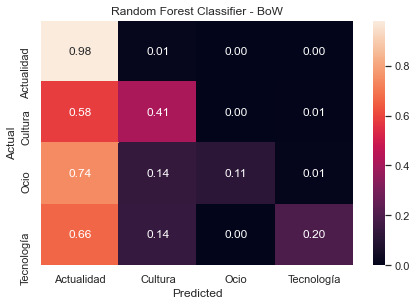

In [51]:
#Modelo
model = RandomForestClassifier().fit(bow_train_x,ytr)

#Predicción
prediction = model.predict(bow_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m6_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Classifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 63.39%


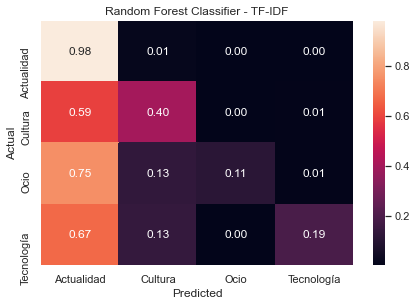

In [52]:
#Modelo
model = RandomForestClassifier().fit(tfidf_train_x,ytr)

#Predicción
prediction = model.predict(tfidf_test_x)
m6_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m6_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Classifier - TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados.append(('Random Forest Clasifier',m6_1,m6_2))

#### 5.7. Comparison of the models: 

In [53]:
data_modelos_1 = pd.DataFrame(lista_resultados, columns=['model', 'f1 score BoW', 'f1 score TF-IDF'])

In [54]:
data_modelos_1

,model,f1 score BoW,f1 score TF-IDF
0,Reg Logística,75.74,74.68
1,Multinomial NB,77.27,75.92
2,SGDC Classifier,73.97,75.58
3,Linear SVC,73.43,76.60
4,Decision Tree Clasifier,60.48,60.20
5,Random Forest Clasifier,63.81,63.39


We can see that decision trees perform significantly worse than the other models. We observe that the models have a high failure rate in the "entertainment" category, which indicates that we need to find a way to improve the results in this aspect. On the other hand, we can see that the F1 score is not entirely decisive in choosing the model since some models predict the majority of instances as "current affairs" and achieve high accuracy in this category, resulting in a good F1 score. Therefore, we need to conduct an analysis of the confusion matrix.

### 6. Class balancing

As we have mentioned, we believe that the results could improve with class balancing since, for example, the leisure class, which often fails our models, only represents **8.3%** of our data, while current affairs represents **56.6%**. In the previous results, we can see that current affairs shows the highest accuracy in our models, and we think it's because it also has a greater number of observations in our dataset. Therefore, class balancing can help us.

There are two ways to balance the classes:

- Undersampling: Removing samples from the overrepresented classes. It is more useful when the dataset is large.
- Oversampling: Adding more samples from the underrepresented classes. It is more useful when the dataset is small.

Since our dataset is large, we will balance the classes using oversampling. We will do this using **SMOTE**, which is an oversampling method that creates synthetic samples of the minority class. We will use the **imblearn** package to oversample the minority classes.
Ç


There is also the option in scikit-learn to balance the classes in models using the class_weight="balanced" parameter. We will do this in some models later on. For now, let's proceed with SMOTE:

In [55]:
smote = SMOTE(random_state = 101)

X_sm_bow, y_sm_bow = smote.fit_resample(bow_train_x, ytr)
X_sm_tfidf, y_sm_tfidf = smote.fit_resample(tfidf_train_x, ytr)

print(X_sm_bow.shape, y_sm_bow.shape)

(61320, 79675) (61320, 1)


<AxesSubplot:ylabel='None'>

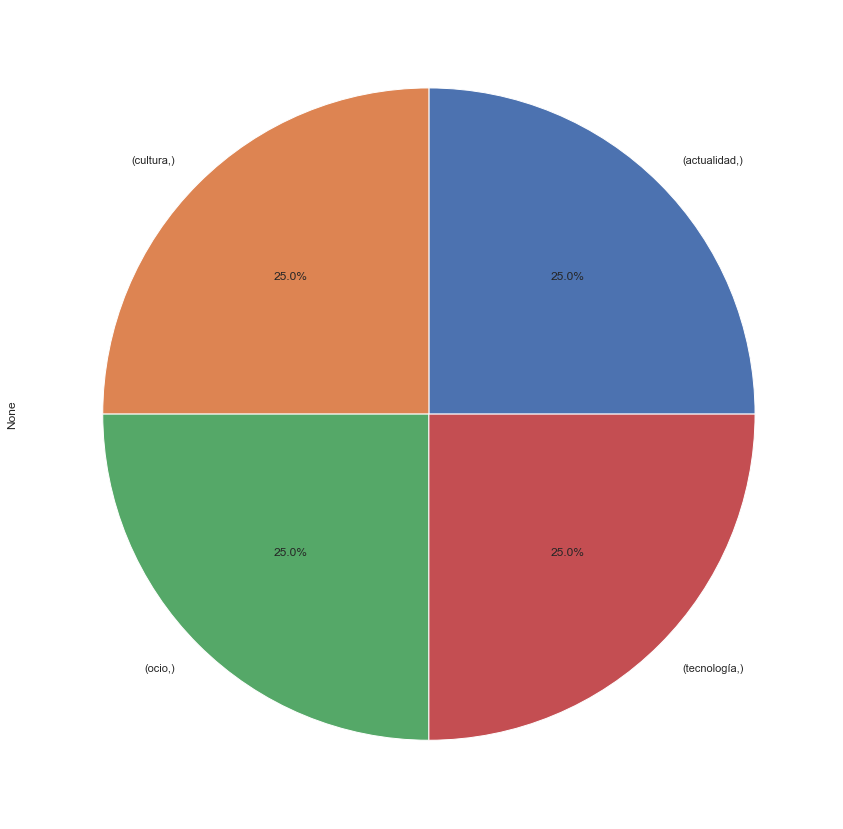

In [56]:
df_sub_bal = pd.DataFrame(data=y_sm_bow)
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df_sub_bal.value_counts().plot.pie( autopct = '%1.1f%%')

Once we have balanced the classes, let's examine the results of the models:

In [57]:
lista_resultados_sm = []

#### 6.1. Logistic Regression:

F1 Score : 74.63%


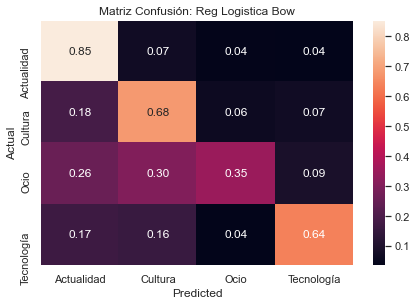

In [58]:
#Modelo
model = LogisticRegression(solver='liblinear').fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m1_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica Bow")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

F1 Score : 77.61%


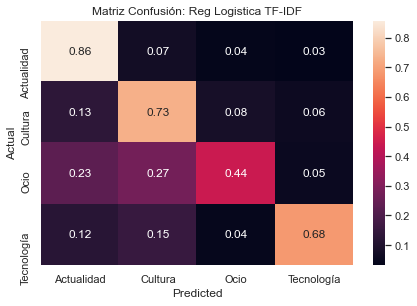

In [59]:
model = LogisticRegression().fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Reg Logistica',m1_1,m1_2))

#### 6.2. Multinomial NB:

F1 Score : 77.59%


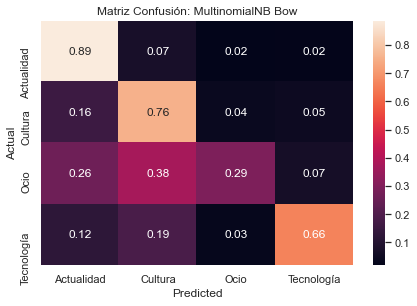

In [60]:
model = MultinomialNB(alpha=0.05).fit(X_sm_bow, y_sm_bow)

prediction = model.predict(bow_test_x)
m2_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB Bow")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


F1 Score : 77.26%


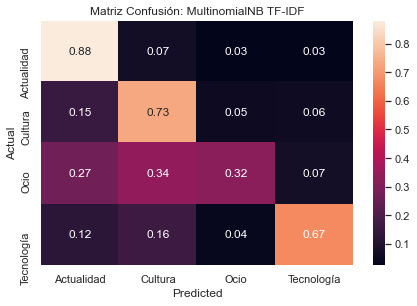

In [61]:
model = MultinomialNB(alpha=0.05).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m2_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: MultinomialNB TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


lista_resultados_sm.append(('Multinomial NB',m2_1,m2_2))

#### 6.3. SGDC Classifier

f1 score: 75.58%


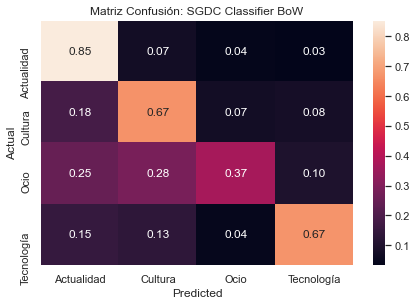

In [62]:
#Modelo
model = SGDClassifier(loss='hinge').fit(X_sm_bow,y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m3_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))


#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDC Classifier BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 77.63%


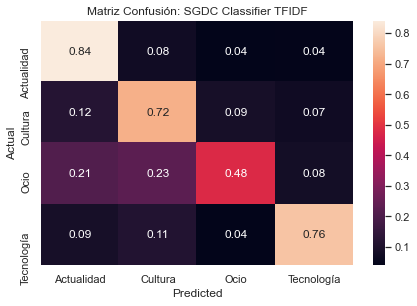

In [63]:
#Modelo
model = SGDClassifier(loss='hinge').fit(X_sm_tfidf,y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m3_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m3_2))


#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDC Classifier TFIDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_resultados_sm.append(('SGDC Classifier',m3_1,m3_2))

#### 6.4 Linear SVC

F1 Score : 71.1%


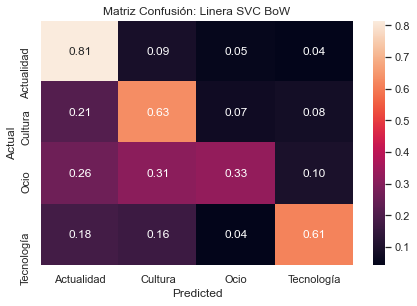

In [64]:
model = LinearSVC().fit(X_sm_bow, y_sm_bow)

prediction = model.predict(bow_test_x)
m4_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


F1 Score : 76.33%


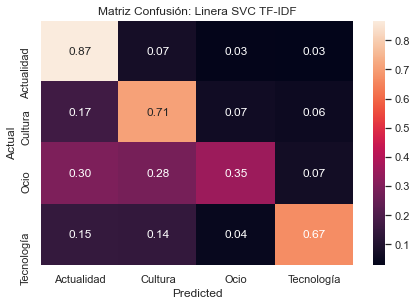

In [65]:
model = LinearSVC().fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Linear SVC',m4_1,m4_2))

#### 6.5. Descicion Tree Classifier

f1 score: 71.1%


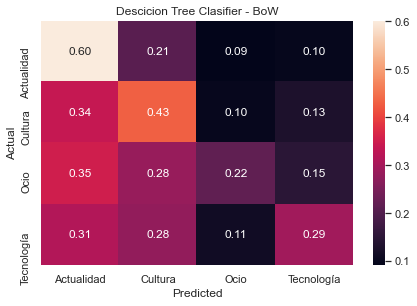

In [66]:
#Modelo
model = DecisionTreeClassifier().fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m5_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Descicion Tree Clasifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 71.1%


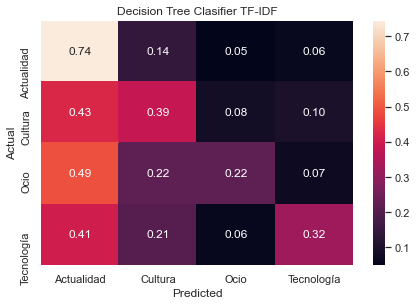

In [67]:
#Modelo
model = DecisionTreeClassifier().fit(X_sm_tfidf, y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m5_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Decision Tree Clasifier TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Decision Tree Clasifier',m5_1,m5_2))

#### 6.6. Random Forest Clasifier

f1 score: 71.1%


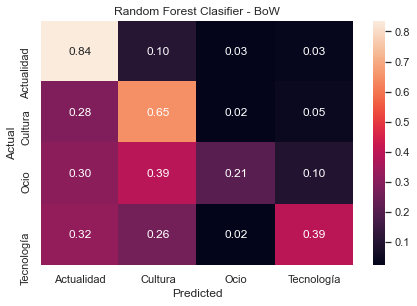

In [68]:
#Modelo
model = RandomForestClassifier().fit(X_sm_bow, y_sm_bow)

#Predicción
prediction = model.predict(bow_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Clasifier - BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

f1 score: 71.1%


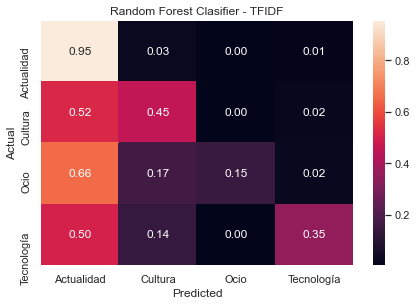

In [69]:
#Modelo
model = RandomForestClassifier().fit(X_sm_tfidf, y_sm_tfidf)

#Predicción
prediction = model.predict(tfidf_test_x)
m6_1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("f1 score: {}%".format(m4_1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Random Forest Clasifier - TFIDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lista_resultados_sm.append(('Random Forest Classifier',m6_1,m6_2))

#### 6.7. Model comparison:

In [70]:
data_modelos_sm = pd.DataFrame(lista_resultados_sm, columns=['model', 'F1 Score BoW','F1 Score TF-IDF'])

In [71]:
print('Con las clases balanceadas:')
data_modelos_sm

Con las clases balanceadas:


,model,F1 Score BoW,F1 Score TF-IDF
0,Reg Logistica,74.63,77.61
1,Multinomial NB,77.59,77.26
2,SGDC Classifier,74.94,77.63
3,Linear SVC,71.10,76.33
4,Decision Tree Clasifier,51.32,56.70
5,Random Forest Classifier,66.87,63.39


- We can see that in this part, we obtain better results in the leisure category compared to the models without balanced classes. We observe that the SGDClassifier with the TF-IDF matrix achieves the best results in leisure, correctly predicting 48% of them, and also performs reasonably well in other classes.

- We prefer to use Logistic Regression with the TF-IDF matrix since it also yields good results and exhibits greater stability compared to the SGDClassifier, which is a variable model with low consistency. For inference purposes, we are interested in working with consistent models.

- The results of the classification trees remain quite poor.

- We did not implement a Support Vector Machine (SVM) due to its high computational cost. Therefore, in the next section, we will explore the LSA algorithm to, among other things, reduce dimensionality and enable the implementation of an SVM.

### 7. Modeling with Topic Modeling - LSA

In this section, we will perform topic modeling with two main purposes. Firstly, we aim to reduce dimensionality to facilitate the use of models like SVC, which took too long with sparse TF-IDF or BOW vectors. Secondly, we want to observe how classifiers perform on a sparse LSA matrix to compare their results later on.

In [72]:
lsa_models = []


In [73]:
svd = TruncatedSVD(n_components=400)
lsa = make_pipeline(tfidf_vectorizer, svd, Normalizer(copy=False))
lsa_topic_vectors = lsa.fit_transform(Xtr)
lsa_test = lsa.transform(Xts)

F1 Score : 76.74%


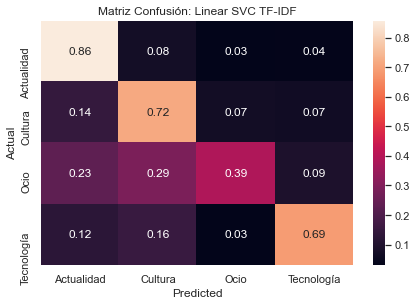

In [74]:
model = LinearSVC(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linear SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('LinearSVC',m1))

F1 Score : 76.03%


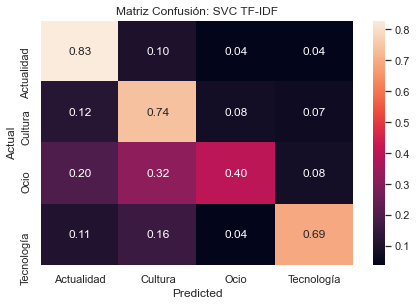

In [75]:
model = SVC(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('SVC',m2))

F1 Score : 73.95%


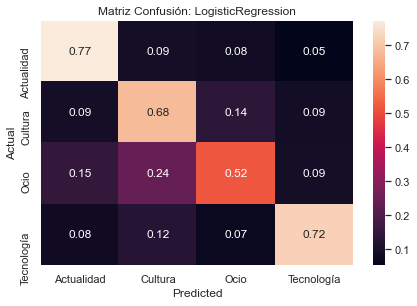

In [76]:
model = LogisticRegression(class_weight='balanced').fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m3))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LogisticRegression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

lsa_models.append(('Logistic Regression',m3))

In [77]:
data_modelos_lsa = pd.DataFrame(lsa_models, columns=['model','F1_Score'])

In [78]:
data_modelos_lsa.head()

,model,F1_Score
0,LinearSVC,76.74
1,SVC,76.03
2,Logistic Regression,73.95


In this case, the model with the highest F1-score is LinearSVC, although SVC also offers very good results, especially when it comes to minority classes. Therefore, we will choose LinearSVC as our preferred model, but it's worth noting the impressive performance of SVC as well.

### 8. Modeling with Doc2Bow

Now we are going to use feature extraction with dense vectors. In sparse models, the numerical vector does not have any direct relationship with the meaning of words. Dense models encode each word/sentence as a numerical vector with semantic information.

In [79]:
def etiquetado(corpus, label_type):
    """
    Para poder modelizar con el Doc2Vec de Gensim, necesito tener etiquetas para cada noticia, donde le
    asociaremos valores si el conjunto está en train o en test con una indexación posteriormente para 
    diferenciar las noticias.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [80]:
Xtr_etiqueta =etiquetado(Xtr,'train')
Xts_etiqueta = etiquetado(Xts,'test')

In [81]:
Data_etiqueta = Xtr_etiqueta + Xts_etiqueta

In [82]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in Data_etiqueta])

for epoch in range(30):
    model_dbow.train(sklearn.utils.shuffle([x for x in Data_etiqueta]), total_examples=len(Data_etiqueta), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [83]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Con esta función obtenemos los vectores para posteriormente poder modelizar con ellos
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(Xtr), 300, 'train')
test_vectors_dbow = get_vectors(model_dbow, len(Xts), 300, 'test')


In [84]:
lista_modelos_doc2bow= []

F1 Score : 72.37 %


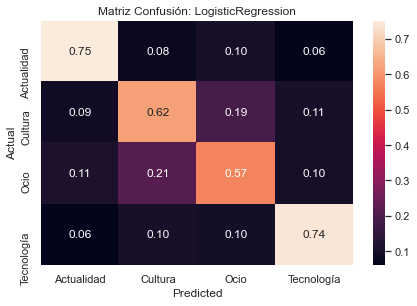

In [85]:
mdc = LogisticRegression(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr,)
prediction = mdc.predict(test_vectors_dbow)
m1 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m1,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LogisticRegression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_modelos_doc2bow.append(('Logistic Regresion',m1))

F1 Score : 75.05 %


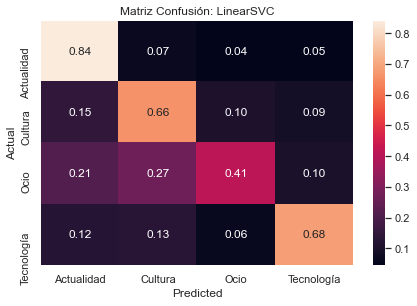

In [86]:
mdc = LinearSVC(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m2,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: LinearSVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')
lista_modelos_doc2bow.append(('LinearSVC',m2))

F1 Score : 76.14 %


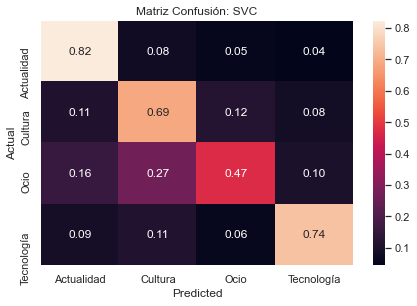

In [87]:
mdc = SVC(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')
lista_modelos_doc2bow.append(('SVC',m3))

F1 Score : 75.13 %


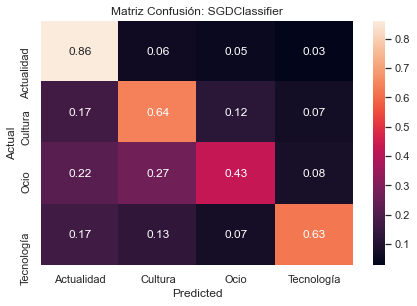

In [88]:
mdc = SGDClassifier(class_weight='balanced')

mdc = mdc.fit(train_vectors_dbow, ytr,)
prediction = mdc.predict(test_vectors_dbow)
m4 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m4,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SGDClassifier")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
lista_modelos_doc2bow.append(('SGDClassifier',m4))

In [89]:
train_y = ytr.to_numpy()

In [90]:
data_modelos_doc2bow = pd.DataFrame(lista_modelos_doc2bow, columns=['model','F1_Score'])

In [91]:
data_modelos_doc2bow

,model,F1_Score
0,Logistic Regresion,72.37
1,LinearSVC,75.05
2,SVC,76.14
3,SGDClassifier,75.13


- We notice that our models significantly improve with the use of dense doc2bow vectors. Thanks to the previous LSA dimensionality reduction, we can now employ SVC without overwhelming computational load.

- SVC proves to be a very good model, one of the best. It achieves accurate predictions for the leisure class while maintaining good precision for the other classes.



### 9. Modeling with Keras:


In this new model, we will use convolutional neural networks to try to find an optimal solution to the problem.

Specifically, without considering computational cost, the best option is to perform convolution to obtain the model. However, due to the high computational cost required for convolution, the approach we will take is to define a multilayer perceptron focused on solving the classification problem.

In [92]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [93]:
import tensorflow as tf

warnings.filterwarnings("ignore")

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(Xtr) # only fit on train

x_train_k = tokenize.texts_to_matrix(Xtr)
x_test_k = tokenize.texts_to_matrix(Xts)

encoder = LabelEncoder()
encoder.fit(ytr)
y_train_k = encoder.transform(ytr)
y_test_k = encoder.transform(yts)

num_classes = np.max(y_train_k) + 1
y_train_k = tf.keras.utils.to_categorical(y_train_k, num_classes)
y_test_k = tf.keras.utils.to_categorical(y_test_k, num_classes)


In [94]:
warnings.filterwarnings("ignore")

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(ytr['sub']),
                                             ytr['sub']))

weights={}
for index, weight in enumerate(class_weights) :
      weights[index]=weight

We define a multilayer perceptron by adding a hidden layer of neurons.

In [95]:

model = Sequential()
batch_size = 32
epochs = 5

model.add(Dense(32, input_shape=(max_words,)))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(32, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(32, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(16, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(8, input_shape=(max_words,)))
model.add(Activation('relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_m])

In [96]:
history = model.fit(x_train_k, y_train_k,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    class_weight = weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
744/744 [==============================] - 43s 3ms/step - loss: 1.3252 - f1_m: 0.1228 - val_loss: 0.9592 - val_f1_m: 0.5517
Epoch 2/5
744/744 [==============================] - 1s 2ms/step - loss: 1.0591 - f1_m: 0.5635 - val_loss: 0.8826 - val_f1_m: 0.6229
Epoch 3/5
744/744 [==============================] - 1s 2ms/step - loss: 0.9458 - f1_m: 0.6250 - val_loss: 0.8391 - val_f1_m: 0.6645
Epoch 4/5
744/744 [==============================] - 1s 2ms/step - loss: 0.8711 - f1_m: 0.6519 - val_loss: 0.8486 - val_f1_m: 0.6616
Epoch 5/5
744/744 [==============================] - 1s 2ms/step - loss: 0.8429 - f1_m: 0.6661 - val_loss: 0.8105 - val_f1_m: 0.6785


In [97]:
warnings.filterwarnings("ignore")
prediction = model.predict_classes(x_test_k)

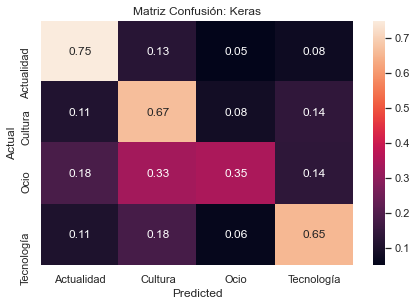

In [98]:
prediction1 = np.where(prediction==0, 'Actualidad', prediction) 
prediction2 = np.where(prediction==1, 'Cultura', prediction1) 
prediction3 = np.where(prediction==2, 'Ocio', prediction2) 
prediction_final = np.where(prediction==3, 'Tecnología', prediction3) 

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction_final)
cm = cm[4:8,0:4]
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Keras")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


The results obtained using a multilayer perceptron are not good, as a good F1 score is not achieved. However, a good solution is obtained for the classification problem of the Leisure category.

### 10. Model Improvment:


With the models that we consider to be the best performers, we are going to include parameters to improve their precision.

#### 10.1. Logistic Regresión con TFIDF -  Balanced Classes


We are going to parameterize the model to improve the results. We would like to remind you that the previous f1_score obtained for this model is **77.61%.**

F1 Score : 77.72%


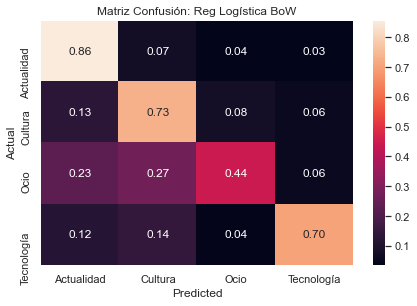

In [99]:
model = LogisticRegression(solver = 'newton-cg',multi_class='ovr',l1_ratio=0.5,C=1.5, random_state=1).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

# Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logística BoW")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### 10.2. Linear SVC - LSA

The previous f1_score obtained for this model is **76.12%**.

F1 Score : 76.74%


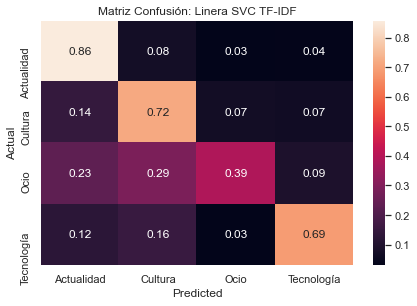

In [100]:
model = LinearSVC(class_weight='balanced',loss = 'squared_hinge',multi_class='ovr',random_state=1).fit(lsa_topic_vectors, ytr)

prediction = model.predict(lsa_test)
m4_2 = round(f1_score(yts, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 10.3. SVC - Dense Vector Doc2Bow

The previous f1_score obtained for this model is **76.43 %**.

F1 Score : 77.1 %


Text(0.5, 17.0, 'Predicted')

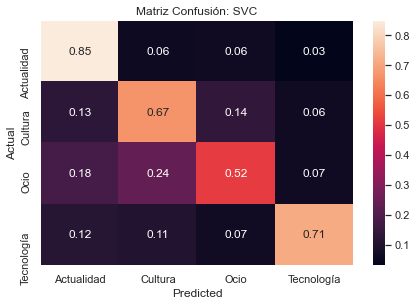

In [101]:
mdc = SVC(class_weight='balanced',kernel = 'poly',decision_function_shape='ovr')

mdc = mdc.fit(train_vectors_dbow, ytr)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(yts, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(yts, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')


### 11. Models on the Test Set


With the two previous models, which have shown the best results on the validation set, we will now evaluate their performance on the test set. This is done to test the models with completely unknown data and see how they perform on new news articles.

While this step may be somewhat irrelevant in this case, it can give us an estimation of how these models would perform on new articles.

We repeat the previous process but with the test sets:

#### 11.1. Logistic Regresión con TFIDF - Balanced Classes

In [102]:
#Creamos los vectorizadores:
bow_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [103]:
# Vamos a entrenar con el conjunto de train los vectorizadores:
bow_train_x = bow_vectorizer.fit_transform(X_train2)  
tfidf_train_x = tfidf_vectorizer.fit_transform(X_train2) 

# Ahora lo aplicamos sobre el conjunto test (el vector ya entrenado):
bow_test_x = bow_vectorizer.transform(X_test2) 
tfidf_test_x = tfidf_vectorizer.transform(X_test2)

In [104]:
smote = SMOTE(random_state = 101)

X_sm_bow, y_sm_bow = smote.fit_resample(bow_train_x, y_train)
X_sm_tfidf, y_sm_tfidf = smote.fit_resample(tfidf_train_x, y_train)

F1 Score : 77.41%


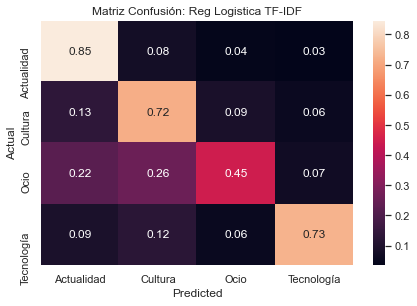

In [105]:
model = LogisticRegression(solver = 'newton-cg',multi_class='ovr',l1_ratio=0.5,C=1.5, random_state=1).fit(X_sm_tfidf, y_sm_tfidf)

prediction = model.predict(tfidf_test_x)
m1_2 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m1_2))

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Reg Logistica TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 11.2. Linear SVC - LSA

In [106]:
svd = TruncatedSVD(n_components=400)
lsa = make_pipeline(tfidf_vectorizer, svd, Normalizer(copy=False))
lsa_topic_vectors = lsa.fit_transform(X_train2)
lsa_test = lsa.transform(X_test2)

F1 Score : 75.89%


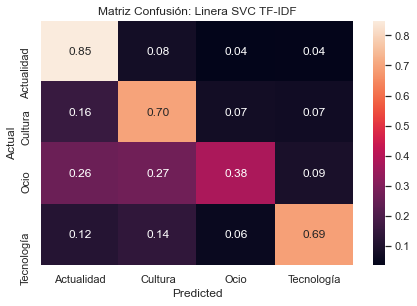

In [107]:
model = LinearSVC(class_weight='balanced',loss = 'squared_hinge',multi_class='ovr',random_state=1).fit(lsa_topic_vectors, y_train)

prediction = model.predict(lsa_test)
m4_2 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print("F1 Score : {}%".format(m4_2))

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: Linera SVC TF-IDF")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


#### 11.3. SVC - Vector denso Doc2Bow

In [108]:
Xtrain_etiqueta = etiquetado(X_train2,'train')
Xtests_etiqueta = etiquetado(X_test2,'test')

In [109]:
Data_etiqueta = Xtrain_etiqueta + Xtests_etiqueta

In [110]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in Data_etiqueta])

for epoch in range(30):
    model_dbow.train(sklearn.utils.shuffle([x for x in Data_etiqueta]), total_examples=len(Data_etiqueta), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [111]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train2), 300, 'train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test2), 300, 'test')

F1 Score : 76.55 %


Text(0.5, 17.0, 'Predicted')

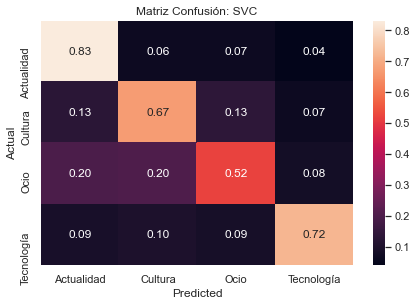

In [112]:
mdc = SVC(class_weight='balanced',kernel = 'poly',decision_function_shape='ovr')

mdc = mdc.fit(train_vectors_dbow, y_train)
prediction = mdc.predict(test_vectors_dbow)
m3 = round(f1_score(y_test, prediction,average='weighted')*100,2)
print('F1 Score : %s' % m3,'%')

#Matriz de connfusión:
cm = confusion_matrix(y_test, prediction)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7,4.5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names).set_title("Matriz Confusión: SVC")
plt.ylabel('Actual')
plt.xlabel('Predicted')


### 12. Conclusion

As a conclusion, we would like to highlight several important points that we have encountered throughout this project:

- Firstly, the models face significant difficulties in predicting the Leisure class, as observed throughout the work. This class tends to be confused with other classes, mainly due to the limited number of samples available. Additionally, it is understandable that Leisure, Culture, and Current Affairs can be easily confused. It is worth mentioning that the news articles in our dataset do not contain a large amount of text. None of the models achieve good predictions in this class without compromising precision in the other classes.

- The improvement achieved through class balancing is noteworthy. We have observed a significant enhancement in classifier predictions when the classes were balanced, especially when using sparse vectors. The class balancing is applied not only to the previous model but also to the sklearn option in the model. This improvement is understandable as Current Affairs had a significantly larger representation compared to other classes.

- We have observed that while the SGDClassifier performs well, we reject it due to its lack of stability. It exhibits large variations, which makes it less reliable for our purposes.

- Among the models, Logistic Regression, SVC, and LinearSVC have shown the best performance. On the other hand, Keras and decision trees, especially, perform poorly in this problem, yielding unsatisfactory results.

- The application of dense vectors using Doc2bow has shown an improvement in predicting the Leisure class compared to other methods of vectorizing the information.


In conclusion, we would choose the Logistic Regression model with the **TF-IDF matrix as it has the highest F1 score among the models we have considered the best**. However, it's worth noting that the other models also perform well, especially in terms of precision for the Leisure class. Since all the models work correctly, we choose the one with the best F1 score.